FOR ORAL CANCER PREDICTION


In [2]:
import glob
import numpy as np
from PIL import Image
from numpy import array
from keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
import keras as k
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report
import joblib
import warnings

from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

2024-01-11 05:02:22.065576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 05:02:22.065631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 05:02:22.066845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 05:02:22.073413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 05:02:23.062110: W tensorflow/compiler/tf2

In [3]:
cancer_imgs = glob.glob('../Dataset/OralCancer/cancer' + '/*.jpg')
non_cancer_imgs = glob.glob('../Dataset/OralCancer/non-cancer/' + '/*.jpg')

In [4]:
dataset = []
labels = []

for img in cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(1)

for img in non_cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(0)
  
dataset = array(dataset)

Cancer Images: 


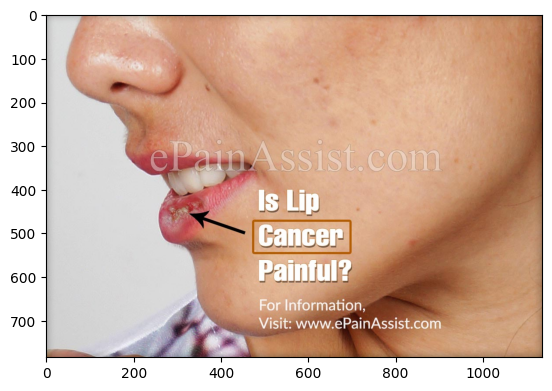

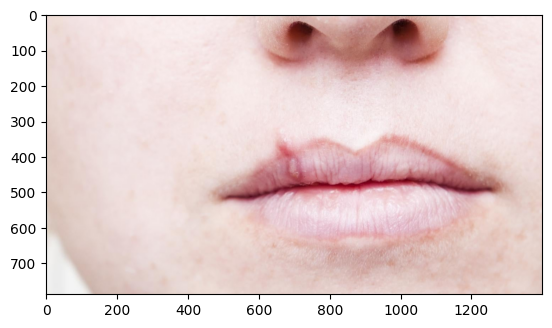

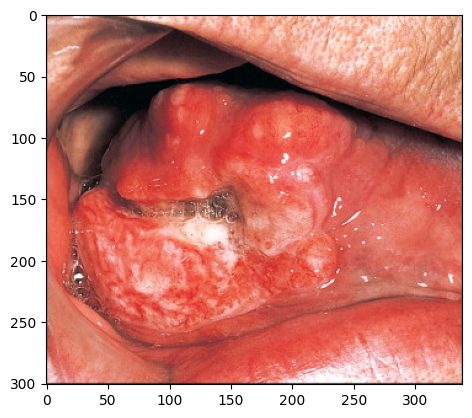

In [5]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline


print('Cancer Images: ')
for img in cancer_imgs[:3]:
  testim = mpimg.imread(img)
  plt.figure()
  imshow(testim)

In [6]:
def evaluate_model(clf, X_test, y_test, model_name):
  print('--------------------------------------------')
  print('Model ', model_name)
  y_pred = clf.predict(X_test)
  f1 = f1_score(y_test, y_pred.round(), average='weighted')
  recall = recall_score(y_test, y_pred.round(), average='weighted')
  precision = precision_score(y_test, y_pred.round(), average='weighted')
 # print(classification_report(y_test, y_pred.round()))
  print("F1 Score ", f1)
  print("Recall ", recall)
  print("Precision ", precision)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=42)
X_train = X_train.reshape(len(X_train),3*64*64)
X_test = X_test.reshape(len(X_test),3*64*64)

In [8]:

oc_clf_tree = tree.DecisionTreeClassifier(random_state=42)
oc_clf_tree = oc_clf_tree.fit(X_train, y_train)

In [9]:

sc = StandardScaler()
X2_train = sc.fit_transform(X_train)
X2_test = sc.transform(X_test)
oc_rf = RandomForestClassifier(n_estimators=2000,criterion='entropy', random_state=0)
oc_rf.fit(X2_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, random_state=0)

In [10]:

oc_svm = svm.SVC(kernel='poly') # Linear Kernel
oc_svm.fit(X_train, y_train)

SVC(kernel='poly')

In [11]:
evaluate_model(oc_clf_tree, X_test, y_test, 'Decision Tree')


--------------------------------------------
Model  Decision Tree
F1 Score  0.6436672325976229
Recall  0.64
Precision  0.6493333333333333


In [12]:
evaluate_model(oc_rf, X2_test, y_test, 'RandomForest')


--------------------------------------------
Model  RandomForest
F1 Score  0.7520588235294119
Recall  0.76
Precision  0.754920634920635


In [13]:
evaluate_model(oc_svm, X_test, y_test, 'SVM')

--------------------------------------------
Model  SVM
F1 Score  0.764
Recall  0.76
Precision  0.7776623376623377


In [14]:

def load_and_convert_to_gray(img_path):
    img = Image.open(img_path).convert('L')  # 'L' mode stands for grayscale
    img_array = image.img_to_array(img.resize((64, 64)))  # Resize to desired dimensions
    return img_array

dataset = []
labels = []


for img in cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(1)

for img in non_cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(0)

dataset = array(dataset)
labels = np.array(labels)
labels_one_hot = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels_one_hot, test_size=0.3, random_state=42)

time_steps = X_train.shape[1]
features = X_train.shape[2]

lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(time_steps, features), activation='relu', return_sequences=True))
lstm_model.add(LSTM(16, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_lstm:.4f}, Test Accuracy: {accuracy_lstm:.4f}')

evaluate_model(lstm_model, X_test, y_test, "LSTM")


Epoch 1/30
1/3 [=========>....................] - ETA: 3s - loss: 25.9644 - accuracy: 0.6562

3/3 [==============================] - 2s 171ms/step - loss: 26.0281 - accuracy: 0.6000 - val_loss: 58.1037 - val_accuracy: 0.4333
Epoch 2/30
3/3 [==============================] - 0s 30ms/step - loss: 79.4071 - accuracy: 0.5429 - val_loss: 425.0298 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 0s 30ms/step - loss: 234.1736 - accuracy: 0.4714 - val_loss: 70.4872 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 0s 28ms/step - loss: 50.3375 - accuracy: 0.5429 - val_loss: 31.8943 - val_accuracy: 0.5667
Epoch 5/30
3/3 [==============================] - 0s 29ms/step - loss: 122.3298 - accuracy: 0.4429 - val_loss: 31.5697 - val_accuracy: 0.6333
Epoch 6/30
3/3 [==============================] - 0s 29ms/step - loss: 79.5215 - accuracy: 0.5286 - val_loss: 136.6649 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 0s 28ms/step - loss: 42.3162 - accuracy: 0.6714 - val_loss: 97.3709 - val_accuracy: 0.5667
Epoch 8/30
3/3 [===

In [15]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)

In [16]:
train_generator = train_datagen.flow_from_directory(
    '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='training'
  )

Found 92 images belonging to 2 classes.


In [17]:
test_generator = train_datagen.flow_from_directory(
     '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'
    
  )

Found 39 images belonging to 2 classes.


Found 131 files belonging to 2 classes.


2024-01-11 05:03:30.625613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2024-01-11 05:03:30.730630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


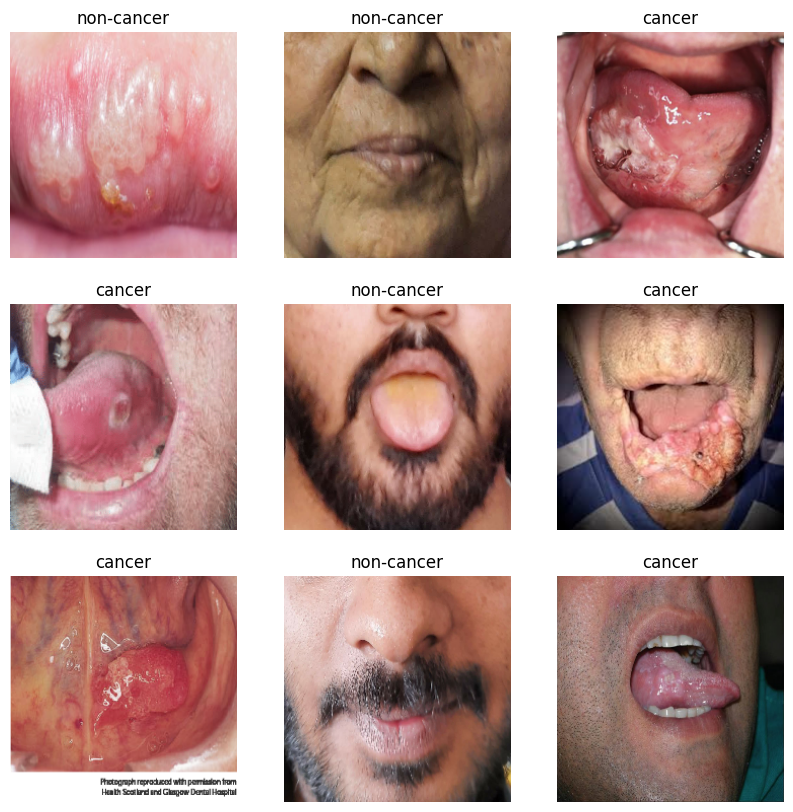

In [18]:
train_dataset = image_dataset_from_directory('../Dataset/OralCancer/',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [19]:
res_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=k.Input(shape=(224,224,3)),
)
for models in res_model.layers[:-1]:
      models.trainable= False
model = k.models.Sequential()
model.add(res_model)
model.add(k.layers.Flatten())
model.add(k.layers.Dense(4, activation='softmax'))
print(model.summary())

94765736/94765736 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [20]:
model.compile(optimizer="adam", loss=k.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [21]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 5)

Epoch 1/5


3/3 [==============================] - 7s 2s/step - loss: 2.6599 - accuracy: 0.3043 - val_loss: 2.5792 - val_accuracy: 0.6667
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1181 - accuracy: 0.5978 - val_loss: 2.9400 - val_accuracy: 0.3333
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.2321 - accuracy: 0.5326 - val_loss: 2.4436 - val_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8113 - accuracy: 0.5000 - val_loss: 1.5637 - val_accuracy: 0.3333
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.1812 - accuracy: 0.5543 - val_loss: 1.2758 - val_accuracy: 0.6667


In [22]:
class_name = {0:"cancer",1:"non cancer"}

In [23]:
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )

2/2 [==============================] - 2s 131ms/step


In [24]:
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
    i += 1
    y = np.argmax(model.predict(data), axis=1)
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
  
    if i == test_generator.samples // 32 + 1:
        break

1/1 [==============================] - 1s 714ms/step


In [25]:
f1 = f1_score(y_pred, y_true, average='weighted')
precision = precision_score(y_pred, y_true, average='weighted')
print("F1 Score ", f1)
print("Precision ", precision)

F1 Score  0.8
Precision  1.0


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

f1 = f1_score(y_pred, y_true, average='weighted')
precision = precision_score(y_pred, y_true, average='weighted')
recall=recall_score(y_pred, y_true, average='weighted')
print("F1 Score ", f1)
print("Precision ", precision)
print("Recall score",recall)

Epoch 1/15
1/3 [=========>....................] - ETA: 3s - loss: 0.9165 - accuracy: 0.3750

3/3 [==============================] - 4s 1s/step - loss: 1.1156 - accuracy: 0.5109 - val_loss: 0.6616 - val_accuracy: 0.6154
Epoch 2/15
3/3 [==============================] - 2s 902ms/step - loss: 0.9755 - accuracy: 0.6522 - val_loss: 0.6431 - val_accuracy: 0.6667
Epoch 3/15
3/3 [==============================] - 2s 878ms/step - loss: 0.6754 - accuracy: 0.7391 - val_loss: 0.6414 - val_accuracy: 0.6667
Epoch 4/15
3/3 [==============================] - 2s 886ms/step - loss: 0.5940 - accuracy: 0.7283 - val_loss: 0.6815 - val_accuracy: 0.5897
Epoch 5/15
3/3 [==============================] - 2s 819ms/step - loss: 0.4410 - accuracy: 0.7935 - val_loss: 0.7034 - val_accuracy: 0.4103
Epoch 6/15
3/3 [==============================] - 2s 836ms/step - loss: 0.4486 - accuracy: 0.7717 - val_loss: 0.7538 - val_accuracy: 0.3333
Epoch 7/15
3/3 [==============================] - 2s 836ms/step - loss: 0.4049 - accuracy: 0.7609 - val_loss: 0.7278 - val_accuracy: 0.3846
Epoch 8/15
2/2 [==================

2/2 [==============================] - 1s 161ms/step
F1 Score  0.8
Precision  1.0
Recall score 0.6666666666666666


In [29]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assuming 'train_generator' is used for training and 'test_generator' for testing
# Assuming you have determined 'num_classes' based on your data
num_classes = 2

# Build the EfficientNetB3 model
efficientnet_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in efficientnet_model.layers:
    layer.trainable = False

# Build your model on top of EfficientNetB3
model = Sequential()
model.add(efficientnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)



Epoch 1/15
3/3 [==============================] - 12s 2s/step - loss: 0.8862 - accuracy: 0.3804 - val_loss: 0.6435 - val_accuracy: 0.6667
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 0.7092 - accuracy: 0.6630 - val_loss: 0.7685 - val_accuracy: 0.6667
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.7472 - accuracy: 0.6630 - val_loss: 0.6641 - val_accuracy: 0.6667
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.6495 - accuracy: 0.6630 - val_loss: 0.6392 - val_accuracy: 0.6667
Epoch 5/15
3/3 [==============================] - 3s 1s/step - loss: 0.6697 - accuracy: 0.6630 - val_loss: 0.6733 - val_accuracy: 0.6667
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 0.6659 - accuracy: 0.6630 - val_loss: 0.6485 - val_accuracy: 0.6667
Epoch 7/15
3/3 [==============================] - 3s 1s/step - loss: 0.6517 - accuracy: 0.6630 - val_loss: 0.6380 - val_accuracy: 0.6667
Epoch 8/15
3/3 [========================

In [30]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Assuming 'train_generator' is used for training and 'test_generator' for testing
# Assuming you have determined 'num_classes' based on your data
num_classes = 2

# Build the VGG19 model
vgg19_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

# Build your model on top of VGG19
model = Sequential()
model.add(vgg19_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print classification report
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)



Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 0.7551 - accuracy: 0.3913 - val_loss: 0.6598 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 8s 3s/step - loss: 0.6595 - accuracy: 0.6630 - val_loss: 0.6374 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 0.6591 - accuracy: 0.6630 - val_loss: 0.6465 - val_accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 8s 3s/step - loss: 0.6597 - accuracy: 0.6630 - val_loss: 0.6385 - val_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 8s 3s/step - loss: 0.6510 - accuracy: 0.6630 - val_loss: 0.6347 - val_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 0.6367 - accuracy: 0.6630 - val_loss: 0.6318 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 8s 3s/step - loss: 0.6299 - accuracy: 0.6630 - val_loss: 0.6292 - val_accuracy: 0.6667
Epoch 8/10
3/3 [=========================